In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

Import the shear wall database

In [2]:
data1 = pd.read_excel('PSS_Database.xlsx', sheet_name='Lognormal', skiprows=0)
data1.head()

,a/d,b/d,ρ,fy/fc,τmax/fc,Unnamed: 5
0,0.604703,0.050047,-3.910563,2.872433,-2.157366,1
1,1.865262,0.766650,-4.451760,2.628314,-2.445042,2
2,1.430746,-0.318454,-4.208076,1.593923,-3.170777,3
3,1.548763,0.492924,-4.605170,2.448494,-2.690119,4
4,2.606490,-0.067659,-4.549750,2.525569,-2.300268,5


In [3]:
len(data1)

380

In [4]:
data=data1.loc[:, 'a/d':'τmax/fc']
data.head()

,a/d,b/d,ρ,fy/fc,τmax/fc
0,0.604703,0.050047,-3.910563,2.872433,-2.157366
1,1.865262,0.766650,-4.451760,2.628314,-2.445042
2,1.430746,-0.318454,-4.208076,1.593923,-3.170777
3,1.548763,0.492924,-4.605170,2.448494,-2.690119
4,2.606490,-0.067659,-4.549750,2.525569,-2.300268


##### Convert the String in Section to numerical values

In [5]:
# Generate X and y data
X = data.loc[:, data.columns != 'τmax/fc']
y=data['τmax/fc']
#X.head()

In [6]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:

import xgboost as xgb
from xgboost import plot_importance
XGB_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
XGB_model.fit(X_train, y_train)

Series.base is deprecated and will be removed in a future version


[12:24:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

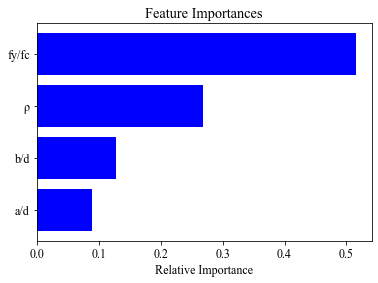

<Figure size 432x288 with 0 Axes>

In [8]:
#XGB_model.feature_importances_
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})


features = list(X.columns.values)

importances = XGB_model.feature_importances_
import numpy as np
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

plt.savefig('Punchingshear_XGBplot.eps',format='eps', dpi=1000)
plt.savefig('Punchingshear_XGBplot.png')

### Explain the SHAP model's predictions on the entire dataset

In [9]:
X_shap = scaler.transform(X)

In [10]:
X_shap = pd.DataFrame(X_shap, columns = X.columns)

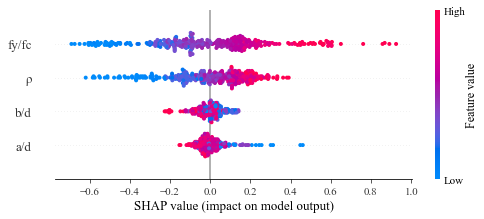

In [11]:
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)

##### The bar plot shows the importance lists of the most significant variables for the failure modes in descending order

## Individual value plot

### visualize the first prediction's explanation
##### 0 corresponds to first row in excel

Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

In [12]:
# Single value explainer
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])

In [13]:
X_shap.iloc[0,:]

a/d      0.349328
b/d      0.464793
ρ        0.745231
fy/fc    0.556591
Name: 0, dtype: float64

### Entire value plot

In [14]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

## Importance plots for various modes of failure

##### In the following plots, the horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

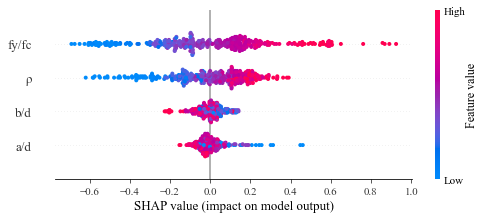

In [15]:
# Importance of Shap value for Class 0 prediction
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
shap.summary_plot(shap_values, X_shap,  show=False)
plt.savefig('Punchingshear_shapplot.eps',format='eps', dpi=1000)
plt.savefig('to.png')

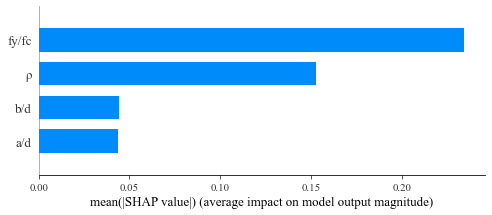

In [16]:
# Importance of Shap value for Class1 (Flexure shear)
shap.summary_plot(shap_values, X_shap,  plot_type="bar", show=False)
plt.savefig('Punchingshear_shap_barplot.eps',format='eps', dpi=1000)

## Dependance plot

SHAP dependence plots shows the marginal effect of a feature  on the expected prediction. The dependence plot helps to see the underlying relation  (e.g., linear, curve, complex,..) of the feature on the outcome. The most dependant variable to the selected variable is shown as a bar on the right side of the axis.

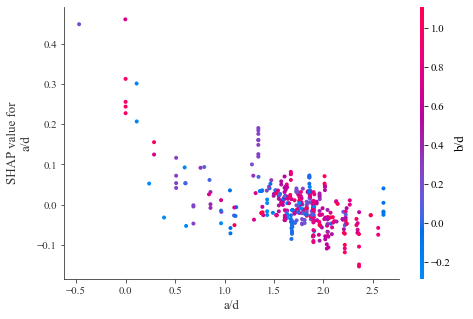

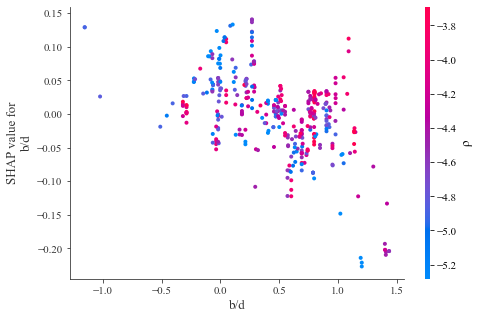

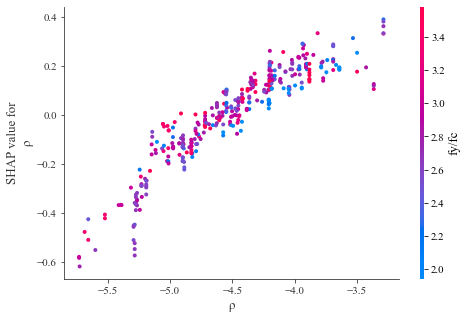

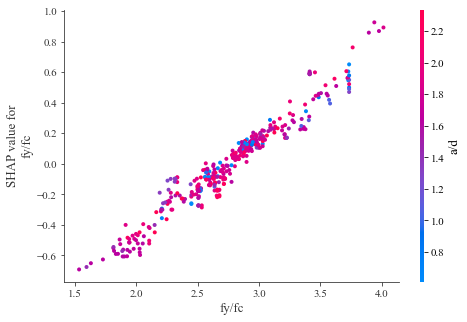

In [17]:
# Plot the dependance plot for class 0
n=1
for name in X_shap.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_shap, show=False )
    
    plt.savefig("Punching_shear_dependance_" + str(n) +".eps", format="EPS")
    n=n+1

